# Function Approximation

This notebook demonstrates how to use a neural network to approximate a mathematical function. We will approximate the function $f(x) = \sin(x) \cdot \cos(2x)$ in the range $[-\pi, \pi]$.

The notebook covers data generation, neural network construction, training, and performance evaluation, providing insights into how neural networks can learn to approximate nonlinear functions.

## Code Implementation

### Importing the Neural Network Library

First, import the necessary classes from the `neural_network` library, as well as supporting libraries for data handling and visualization.

In [252]:
import logging

import matplotlib.pyplot as plt
import numpy as np

from neural_network.layer import HiddenLayer, InputLayer, OutputLayer
from neural_network.math.activation_functions import LinearActivation, TanhActivation
from neural_network.neural_network import NeuralNetwork

logging.basicConfig(format="%(asctime)s %(message)s", datefmt="[%d-%m-%Y|%I:%M:%S]", level=logging.INFO)
logger = logging.getLogger(__name__)
rng = np.random.default_rng()


In [253]:
# Neural network parameters
HIDDEN_LAYER_SIZES = [32, 16, 8]
INPUT_ACTIVATION = LinearActivation
HIDDEN_ACTIVATION = TanhActivation
OUTPUT_ACTIVATION = LinearActivation
WEIGHTS_RANGE = (-1, 1)
BIAS_RANGE = (-0.2, 0.2)
LR = 0.01

# Dataset parameters
DATASET_SIZE = 2000
TRAIN_SIZE_RATIO = 0.8
NUM_EPOCHS = 100

# Function parameters
X_RANGE = (-np.pi, np.pi)

### Define the Target Function and Generate Data

In this section, we define the target function $f(x) = \sin(x) \cdot \cos(2x)$ that our neural network will learn to approximate. 

We'll also create functions to:
- Generate training data points from this function
- Split the data into training and testing sets
- Calculate errors between expected and actual outputs
- Shuffle the dataset for better training

These utility functions are essential for supervised learning.

In [254]:
def target_function(x: float) -> float:
    return np.sin(x) * np.cos(2 * x)


def training_data_from_num(num: int) -> tuple[float, float]:
    """
    Generate target function outputs from a number to use in training.

    Parameters:
        num (int): Number to use for training data

    Returns:
        training_data (tuple[float, float]): Input and expected output
    """
    return ([num / np.pi], target_function(num))

def generate_supervised_training_data(dataset_size: int, x_range: tuple[float, float]) -> list[tuple[float, float]]:
    """
    Generate a supervised dataset for training.
    The dataset consists of pairs of input values and their corresponding outputs from the target function.

    Parameters:
        dataset_size (int): The number of data points to generate.
        x_range (tuple[float, float]): The range of x values to use for generating the dataset.

    Returns:
        list: A list of tuples, where each tuple contains an input value and its corresponding output from the target function.
    """
    x = np.linspace(*x_range, dataset_size)
    return [training_data_from_num(num) for num in x]

def shuffle_data(data: list[tuple[float, float]]) -> list[tuple[float, float]]:
    """
    Shuffle the dataset.

    Parameters:
        data (list[tuple[float, float]]): The dataset to shuffle.

    Returns:
        list: The shuffled dataset.
    """
    rng.shuffle(data)
    return data

def split_data(
    data: list[tuple[float, float]], train_size_ratio: float = TRAIN_SIZE_RATIO
) -> tuple[list[tuple[float, float]], list[tuple[float, float]]]:
    """
    Split the dataset into training and testing sets.

    Parameters:
        data (list[tuple[float, float]]): The dataset to split.
        train_size_ratio (float): The proportion of the dataset to include in the training split.

    Returns:
        tuple: A tuple containing the training and testing datasets.
    """
    train_size = int(len(data) * train_size_ratio)
    data = shuffle_data(data)
    train_data = data[:train_size]
    test_data = data[train_size:]
    return train_data, test_data


def calculate_errors(expected_outputs: np.ndarray, actual_outputs: np.ndarray) -> np.ndarray:
    """
    Calculate the error between expected and actual outputs.

    Parameters:
        expected_outputs (np.ndarray): The expected output values.
        actual_outputs (np.ndarray): The actual output values.

    Returns:
        errors (np.ndarray): The calculated errors.
    """
    return expected_outputs - actual_outputs


def calculate_percentage_error(errors: np.ndarray) -> float:
    """
    Calculate the percentage error from a list of errors.

    Parameters:
        errors (np.ndarray): The list of errors.

    Returns:
        percentage_error (float): The average error as a percentage.
    """
    avg_error = np.average(errors)
    return np.abs(avg_error) * 100

### Neural Network Creation

The following functions are used to create and test neural networks using the parameters defined earlier in this notebook.

In [255]:
def create_nn(
    hidden_layer_sizes: list[int] = HIDDEN_LAYER_SIZES,
    input_activation: type = INPUT_ACTIVATION,
    hidden_activation: type = HIDDEN_ACTIVATION,
    output_activation: type = OUTPUT_ACTIVATION,
    weights_range: tuple[float, float] = WEIGHTS_RANGE,
    bias_range: tuple[float, float] = BIAS_RANGE,
    lr: float = LR,
) -> NeuralNetwork:
    """Create a neural network with specified parameters."""
    input_layer = InputLayer(size=1, activation=input_activation)
    hidden_layers = [
        HiddenLayer(size=size, activation=hidden_activation, weights_range=weights_range, bias_range=bias_range)
        for size in hidden_layer_sizes
    ]
    output_layer = OutputLayer(size=1, activation=output_activation, weights_range=weights_range, bias_range=bias_range)

    return NeuralNetwork.from_layers(layers=[input_layer, *hidden_layers, output_layer], lr=lr)


def evaluate_nn(nn: NeuralNetwork, data: list[tuple[list[float], float]]) -> tuple[np.ndarray, float]:
    """
    Evaluate the neural network on a dataset.

    Parameters:
        nn (NeuralNetwork): The neural network to evaluate.
        data (list[tuple[list[float], float]]): The dataset to evaluate on.

    Returns:
        errors (np.ndarray): The list of errors.
        percentage_error (float): The average error as a percentage.
    """
    dataset_size = len(data)
    outputs = []
    expected = []

    for i in range(dataset_size):
        inputs = data[i][0]
        expected_output = data[i][1]
        output = nn.feedforward(inputs)[0]
        outputs.append(output)
        expected.append(expected_output)

    errors = calculate_errors(
        expected_outputs=np.array(expected), actual_outputs=np.array(outputs)
    )
    percentage_error = calculate_percentage_error(errors)
    return errors, percentage_error

### Training the Neural Network

Now we can run the training algorithm and test the neural network to evaluate its accuracy.
First, we will use the supervised learning approach:

In [256]:
logger.info("Creating neural network for supervised training...")
nn_supervised = create_nn()
logger.info("Generating supervised training data with %s data points...", DATASET_SIZE)
data_supervised = generate_supervised_training_data(DATASET_SIZE, X_RANGE)
training_data_supervised, testing_data_supervised = split_data(data_supervised)
logger.info("Training neural network with %s data points for %s epochs...", len(training_data_supervised), NUM_EPOCHS)
nn_supervised.run_supervised_training(
    inputs=[input_data for input_data, _ in training_data_supervised],
    expected_outputs=[expected_output for _, expected_output in training_data_supervised],
    epochs=NUM_EPOCHS,
)

logger.info("Testing neural network with %s data points...", len(testing_data_supervised))
errors, percentage_error = evaluate_nn(nn_supervised, testing_data_supervised)
avg_error = np.average(errors)
logger.info("Average error: %.4f", avg_error)
logger.info("Supervised training percentage error: %.4f%%", percentage_error)

[05-06-2025|09:32:40] Creating neural network for supervised training...
[05-06-2025|09:32:40] Generating supervised training data with 2000 data points...
[05-06-2025|09:32:40] Training neural network with 1600 data points for 100 epochs...
[05-06-2025|09:33:12] Testing neural network with 400 data points...
[05-06-2025|09:33:12] Average error: 0.0004
[05-06-2025|09:33:12] Supervised training percentage error: 0.0376%


### Testing and Visualization

We can visualise the results by comparing the neural network outputs with the actual outputs of the target function.

In [257]:
def plot_results(nn: NeuralNetwork, title: str) -> None:
    """
    Plot the results of the neural network against the target function.

    Parameters:
        nn (NeuralNetwork): The neural network to plot.
        title (str): The title of the plot.
    """
    x = np.linspace(*X_RANGE, 100)
    y_true = [target_function(num) for num in x]
    y_pred = [nn.feedforward([num/np.pi])[0] for num in x]

    plt.figure(figsize=(10, 5))
    plt.plot(x, y_true, label="Target Function", color="blue")
    plt.plot(x, y_pred, label="Neural Network Output", color="red")
    plt.title(title)
    plt.xlabel("Input")
    plt.ylabel("Output")
    plt.legend()
    plt.grid()
    plt.show()

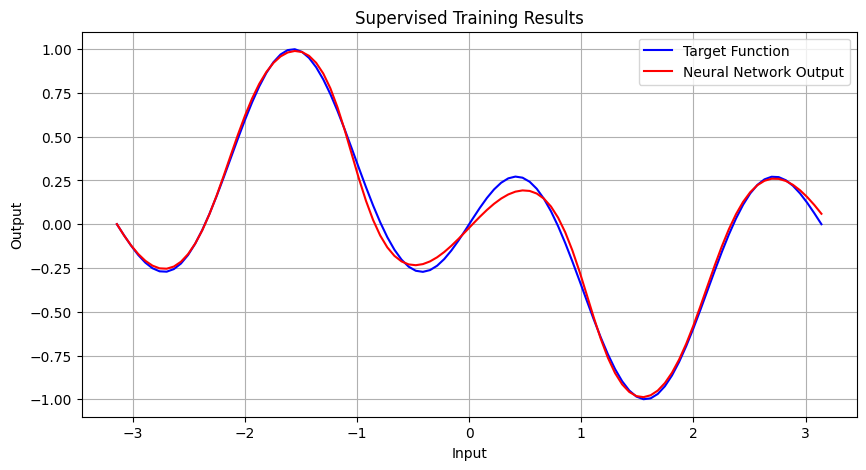

In [258]:
plot_results(nn_supervised, "Supervised Training Results")